In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

In [4]:
url = "https://zenodo.org/record/15854383/files/soil_phosphorus_adsorption_data.xlsx"
df = pd.read_excel(url)

df.head()

,id,code,Soil Classification,Soil texture,C,Si,S,pH,EC,CaCO3,...,1ppm_applied,2ppm_applied,4ppm_applied,6ppm_applied,10ppm_applied,1ppm_adsorbed,2ppm_adsorbed,4ppm_adsorbed,6ppm_adsorbed,10ppm_adsorbed
0,4,1053,Loamy,SCL,24,24,52,4.54,0.336,0.0,...,5.35860,10.7172,21.4344,32.1516,53.5860,5.216276,10.311822,20.682160,31.260304,52.135641
1,5,1055,Loamy,SL,20,28,52,5.76,0.449,0.0,...,5.39295,10.7859,21.5718,32.3577,53.9295,5.341016,10.336667,20.503187,30.689553,50.442041
2,6,1057,Loamy,CL,32,24,44,4.95,0.244,0.0,...,5.15250,10.3050,20.6100,30.9150,51.5250,5.058673,10.213389,20.295749,30.403460,50.937100
3,7,1059,Loamy,SCL,28,24,48,4.80,0.265,0.0,...,5.22120,10.4424,20.8848,31.3272,52.2120,5.174940,10.246448,20.405650,30.795369,50.953534
4,51,1069,Loamy,L,18,34,48,7.48,0.397,20.8,...,5.11815,10.2363,20.4726,30.7089,51.1815,4.479507,9.494015,18.376922,26.764393,39.527575


Phosphorus applied and adsorbed is expressed in kg/stremma

In [5]:
#convert to kg/ha
df['1ppm_adsorbed'] = 10 * df['1ppm_adsorbed']
df['2ppm_adsorbed'] = 10 * df['2ppm_adsorbed']
df['4ppm_adsorbed'] = 10 * df['4ppm_adsorbed']
df['6ppm_adsorbed'] = 10 * df['6ppm_adsorbed']
df['10ppm_adsorbed'] = 10 * df['10ppm_adsorbed']

In [6]:
# convert absorbed P to mg/kg of soil
df['1ppm_adsorbed'] = (df['1ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['2ppm_adsorbed'] = (df['2ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['4ppm_adsorbed'] = (df['4ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['6ppm_adsorbed'] = (df['6ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)
df['10ppm_adsorbed'] = (df['10ppm_adsorbed']*0.4364*1000000)/(df['ΦΕΒ']*15*10000)

In [8]:
# Select only the necessary columns
df_final = df[['S', 'C', 'Si', 'pH', 'EC', 'Organic matter', 'CaCO3',
       'NO3', 'P', 'K', 'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B',
        '1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']]

In [23]:
# data wrangling
from dslectures.core import (
    get_dataset,
    display_large,
    convert_strings_to_categories,
    rf_feature_importance,
    plot_feature_importance,
    plot_dendogram,
)
from dslectures.structured import proc_df
from pathlib import Path

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay , RocCurveDisplay
from sklearn.tree import plot_tree

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay , accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import scipy
from scipy.cluster import hierarchy as hc

In [25]:
df2 = df_final.drop(columns=['1ppm_adsorbed', '2ppm_adsorbed',
       '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed'])

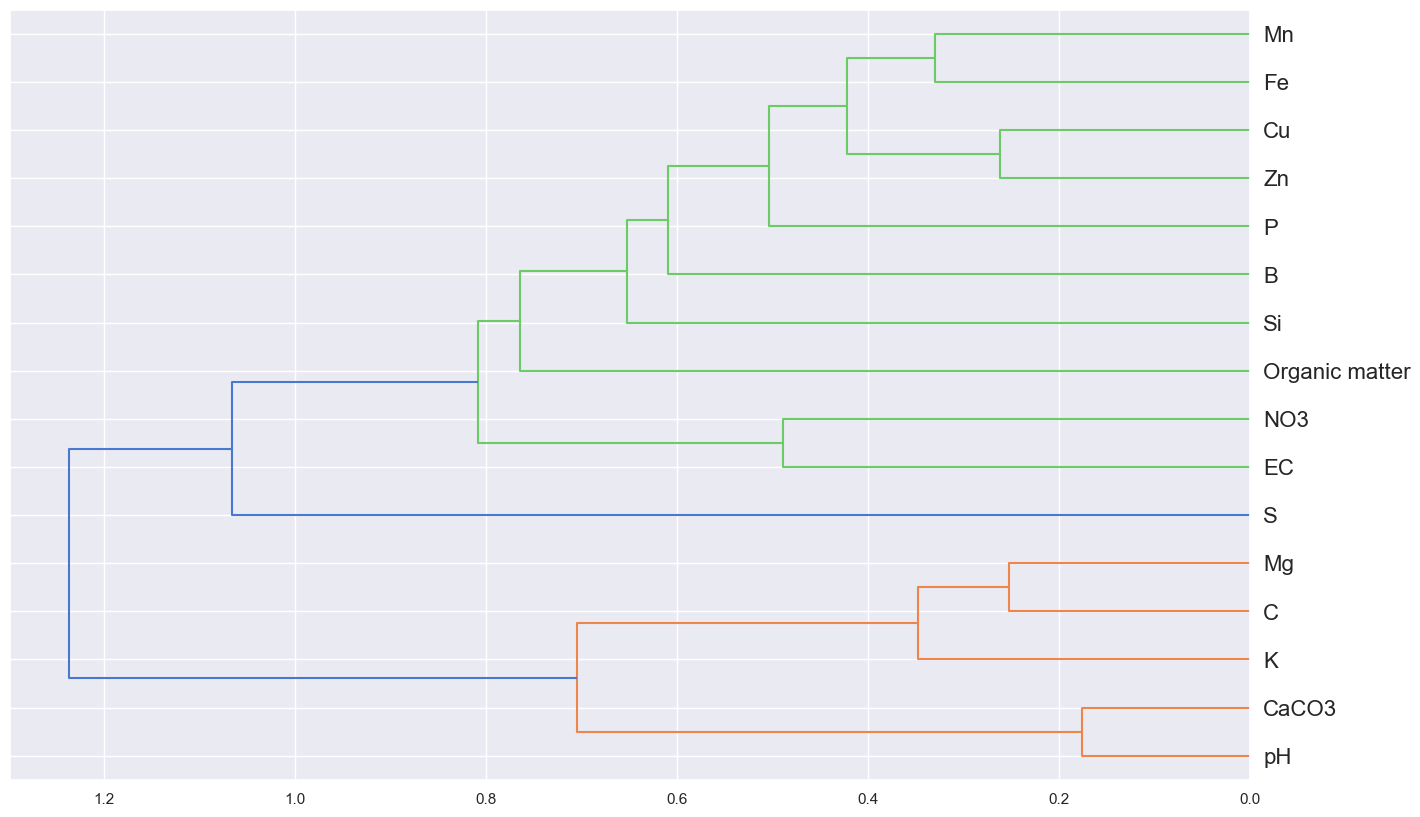

In [26]:
plot_dendogram(df2)

In [30]:
# Create a new dataset by pairing each set of soil features with each Ce level (1, 2, 4, 6, 10 mg/L)
# and the corresponding adsorbed phosphorus value (q). This transforms the original wide-format data
# into a long-format dataset suitable for supervised learning or regression (e.g., modeling q as a function of soil features and Ce).

Ce_values = [1, 2, 4, 6, 10]
q_columns = ['1ppm_adsorbed', '2ppm_adsorbed', '4ppm_adsorbed', '6ppm_adsorbed', '10ppm_adsorbed']
soil_feature_names = ['S', 'C', 'Si', 'pH', 'EC', 'Organic matter', 'CaCO3', 'NO3', 'P', 'K',
       'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B',]

#'Fe', 'NO3', 'B', 'C', 'Si', pH, 'EC','Cu',

rows = []

for _, row in df_final.iterrows():
    soil_features = row[soil_feature_names].values.astype(float)
    for i, Ce in enumerate(Ce_values):
        q = row[q_columns[i]]
        combined = list(soil_features) + [Ce]
        rows.append(combined + [q])

# Create DataFrame
columns = soil_feature_names + ['Ce'] + ['q']
df_seq = pd.DataFrame(rows, columns=columns)

In [31]:
from fastai.tabular.all import *

In [32]:
pd.options.mode.chained_assignment = None  # default='warn'

In [33]:
cat_vars = []

In [34]:
cont_vars = ['S', 'C', 'Si', 'pH', 'EC', 'Organic matter', 'CaCO3', 'NO3', 'P', 'K',
       'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B', 'Ce', ]

In [36]:
df_seq.columns

Index(['S', 'C', 'Si', 'pH', 'EC', 'Organic matter', 'CaCO3', 'NO3', 'P', 'K',
       'Mg', 'Fe', 'Zn', 'Mn', 'Cu', 'B', 'Ce', 'q'],
      dtype='object')

In [37]:
df_seq.shape

(735, 18)

In [38]:
dep_var =  'q'

In [94]:
splits = RandomSplitter(valid_pct=0.2, seed=2)(range_of(df_seq))

In [95]:
procs = [Categorify, FillMissing]

In [96]:
to = TabularPandas(df_seq, procs, cat_vars, cont_vars, dep_var, y_block=RegressionBlock(),
                   splits=splits, inplace=True, reduce_memory=True)

In [97]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [98]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [99]:
# compute the ANOVA F-statistic for each column
select = SelectKBest(f_classif, k=5)
fit = select.fit(xs, y)

divide by zero encountered in divide


In [100]:
p_values = {col: np.round(p_value, 4) for col, p_value in zip(xs.columns, fit.pvalues_)}

In [101]:
print(p_values)

{'S': 0.064, 'C': 0.0005, 'Si': 0.0462, 'pH': 0.0, 'EC': 0.0, 'Organic matter': 0.5172, 'CaCO3': 0.7098, 'NO3': 0.0, 'P': 0.0, 'K': 0.0376, 'Mg': 0.5951, 'Fe': 1e-04, 'Zn': 0.0315, 'Mn': 0.0011, 'Cu': 0.0009, 'B': 0.7114, 'Ce': 0.0}


In [102]:
from sklearn.ensemble import RandomForestRegressor

In [103]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()),6)

In [104]:
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [105]:
def rf(xs, y, n_estimators = 15, max_features = 0.5, min_samples_leaf = 5, **kwargs):
    return  RandomForestRegressor(n_jobs = -1, n_estimators = n_estimators, max_features = max_features, min_samples_leaf = min_samples_leaf, oob_score = True, **kwargs).fit(xs,y)

In [106]:
m = rf(xs, y)

In [107]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(56.975486, 67.239682)

In [108]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeRegressor was fitted without feature names
X has feature names, but DecisionTreeReg

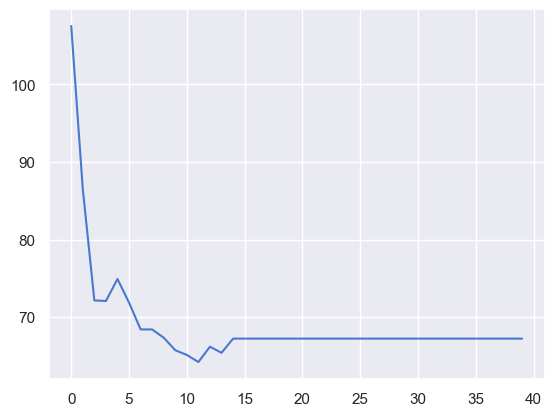

In [109]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

In [110]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [111]:
regressor = RandomForestRegressor(criterion= 'absolute_error',
 bootstrap= True,
 max_depth= 35,
 max_features= None,
 max_leaf_nodes= 22,
 n_estimators= 317,
 n_jobs=2)

In [112]:
regressor.fit(xs ,y)

RandomForestRegressor(criterion='absolute_error', max_depth=35,
                      max_features=None, max_leaf_nodes=22, n_estimators=317,
                      n_jobs=2)

In [113]:
fi = rf_feat_importance(regressor, xs)
fi[:50]

,cols,imp
16,Ce,0.910163
13,Mn,0.023862
0,S,0.015012
8,P,0.010214
1,C,0.006474
4,EC,0.005281
10,Mg,0.005048
5,Organic matter,0.005000
14,Cu,0.003553
11,Fe,0.003379


<Axes: ylabel='cols'>

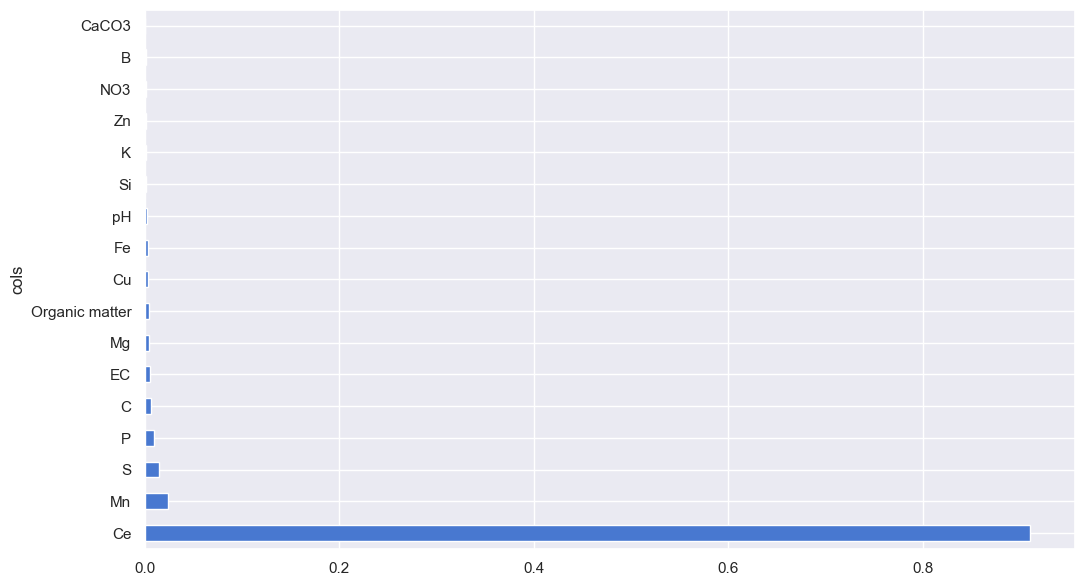

In [114]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:41])

In [115]:
import optuna
from sklearn.model_selection import cross_val_score

In [116]:
def objective(trial):
    # Hyperparameter suggestions
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 500)
    n_estimators = trial.suggest_int('n_estimators', 30, 1000)

    # Define the model
    regr = RandomForestRegressor(
        bootstrap=bootstrap, criterion=criterion,
        max_depth=max_depth, max_features=max_features,
        max_leaf_nodes=max_leaf_nodes, n_estimators=n_estimators,
        random_state=42, n_jobs=2
    )

    # Cross-validation scoring
    score = cross_val_score(regr, xs, y, cv=5, scoring="neg_mean_absolute_error")
    mae_mean = -score.mean()  # Convert negative MAE to positive

    return mae_mean


In [117]:
# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Display the best MAE and hyperparameters
print("Best MAE:", study.best_value)  # Now it displays MAE
print("Best Hyperparameters:", study.best_params)

[I 2025-07-09 12:30:13,011] A new study created in memory with name: no-name-60607303-e55e-40ef-a3f8-90115123d1da


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-09 12:30:23,231] Trial 0 finished with value: 69.57817784714462 and parameters: {'criterion': 'absolute_error', 'bootstrap': True, 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': 305, 'n_estimators': 717}. Best is trial 0 with value: 69.57817784714462.
[I 2025-07-09 12:30:29,345] Trial 1 finished with value: 66.12347152706573 and parameters: {'criterion': 'absolute_error', 'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 222, 'n_estimators': 312}. Best is trial 1 with value: 66.12347152706573.
[I 2025-07-09 12:30:30,872] Trial 2 finished with value: 45.03766793646248 and parameters: {'criterion': 'squared_error', 'bootstrap': False, 'max_depth': 24, 'max_features': None, 'max_leaf_nodes': 300, 'n_estimators': 75}. Best is trial 2 with value: 45.03766793646248.
[I 2025-07-09 12:30:38,363] Trial 3 finished with value: 44.89929695019886 and parameters: {'criterion': 'squared_error', 'bootstrap': False, 'max_depth': 49, 'max_features': None

In [126]:
regressor = RandomForestRegressor(criterion= 'absolute_error',
 bootstrap= True,
 max_depth= 41,
 max_features= None,
 max_leaf_nodes= 212,
 n_estimators= 481,
 n_jobs=2)

In [127]:
regressor.fit(xs ,y)

RandomForestRegressor(criterion='absolute_error', max_depth=41,
                      max_features=None, max_leaf_nodes=212, n_estimators=481,
                      n_jobs=2)

In [128]:
predictions = regressor.predict(valid_xs)

In [129]:
fi = rf_feat_importance(regressor, xs)
fi[:50]

,cols,imp
16,Ce,0.833895
13,Mn,0.029083
0,S,0.019959
8,P,0.017103
4,EC,0.011596
5,Organic matter,0.010716
1,C,0.010096
10,Mg,0.009459
14,Cu,0.008691
12,Zn,0.007623


In [138]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [123]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)

In [125]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Fix randomness as much as possible
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)

# RFE selection
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(xs, y)

# Transform the data
X_train_rfe = rfe.transform(xs)
X_test_rfe = rfe.transform(valid_xs)

# Re-train the final model
model.fit(X_train_rfe, y)
y_pred = model.predict(X_test_rfe)

# Get selected features
selected_features = xs.columns[rfe.support_]
print("Selected Features:")
print(selected_features.tolist())


Selected Features:
['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu', 'Ce']


In [181]:
df_seq= df_seq[['S', 'C', 'pH', 'EC', 'Organic matter', 'P', 'Mg', 'Mn', 'Cu', 'Ce', 'q']]

In [182]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Your data (assuming df_seq with 'q' as target)
X = df_seq.drop(columns='q')
y = df_seq['q']

# Optional: fix split for repeatability
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 10),
        "tree_method": "hist",  # Faster training
        "random_state": 42,
    }

    # Train model
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae  # 📌 Minimize MAE


In [183]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-07-09 15:02:05,809] A new study created in memory with name: no-name-31cf9b0b-24fe-43ed-9601-f520cc4f15e3
[I 2025-07-09 15:02:06,333] Trial 0 finished with value: 25.372362438340183 and parameters: {'n_estimators': 723, 'max_depth': 7, 'learning_rate': 0.03025342739076981, 'subsample': 0.8892855757759177, 'colsample_bytree': 0.9990464713614255, 'reg_alpha': 1.6559154275663568, 'reg_lambda': 8.407502903703634}. Best is trial 0 with value: 25.372362438340183.
[I 2025-07-09 15:02:07,070] Trial 1 finished with value: 27.35857663121808 and parameters: {'n_estimators': 842, 'max_depth': 12, 'learning_rate': 0.14783102567173967, 'subsample': 0.8892345872936817, 'colsample_bytree': 0.8388315554615127, 'reg_alpha': 8.217858358869426, 'reg_lambda': 6.718185191425966}. Best is trial 0 with value: 25.372362438340183.
[I 2025-07-09 15:02:07,168] Trial 2 finished with value: 50.32856988012556 and parameters: {'n_estimators': 185, 'max_depth': 6, 'learning_rate': 0.018953640807714743, 'subsam

In [184]:
print("✅ Best trial:")
print("  MAE:", study.best_value)
print("  Params:", study.best_params)

✅ Best trial:
  MAE: 21.466686159651655
  Params: {'n_estimators': 982, 'max_depth': 3, 'learning_rate': 0.27208365859982553, 'subsample': 0.97627189343494, 'colsample_bytree': 0.5718101476938309, 'reg_alpha': 5.89216838978434, 'reg_lambda': 3.5049056847307365}


In [149]:
import xgboost as xgb

In [187]:
model = xgb.XGBRegressor(n_estimators=946, max_depth=3, learning_rate=0.09811568044385376, subsample=0.9875970710313593,
                         colsample_bytree=0.8580298658924786, reg_alpha=4.698462536406095, reg_lambda=2.541832164878369
                         )

In [191]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

X = df_seq.drop(columns='q')
y = df_seq['q']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)  # ✅ compute R²

print(f"MAE: {mae:.2f} mg/kg")
print(f"R²: {r2:.3f}")

MAE: 22.38 mg/kg
R²: 0.956


In [171]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

model.fit(xs, y)

y_pred = model.predict(valid_xs)
mae = mean_absolute_error(valid_y, y_pred)

r2 = r2_score(valid_y, y_pred)  # ✅ compute R²

print(f"MAE: {mae:.2f} mg/kg")
print(f"R²: {r2:.3f}")

MAE: 22.47 mg/kg
R²: 0.979


In [195]:
import shap

# Create explainer from the trained model
explainer = shap.Explainer(model, X_train)

# Compute SHAP values on test set
shap_values = explainer(X_test)

[15:06:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[15:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


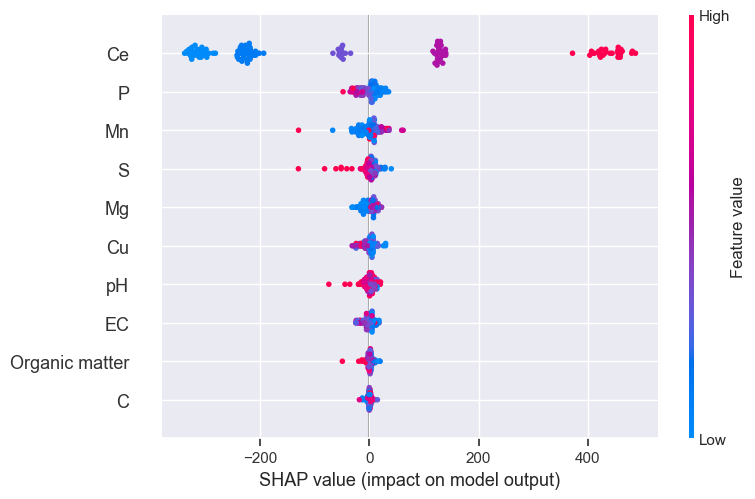

In [196]:
shap.plots.beeswarm(shap_values, max_display=30)

In [197]:
shap_values = explainer.shap_values(X_train)

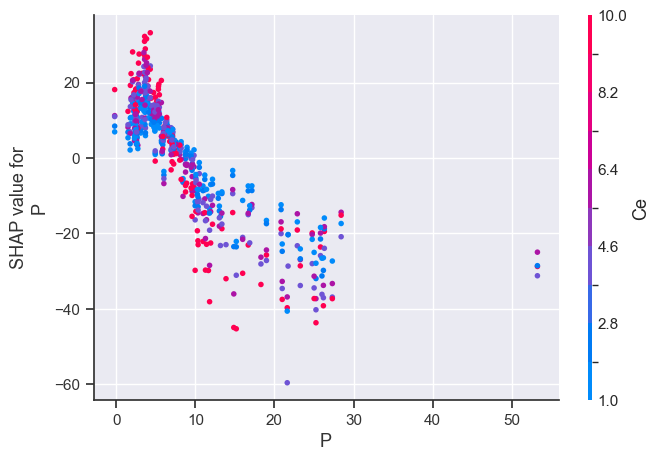

In [198]:
shap.dependence_plot('P',shap_values,X_train)

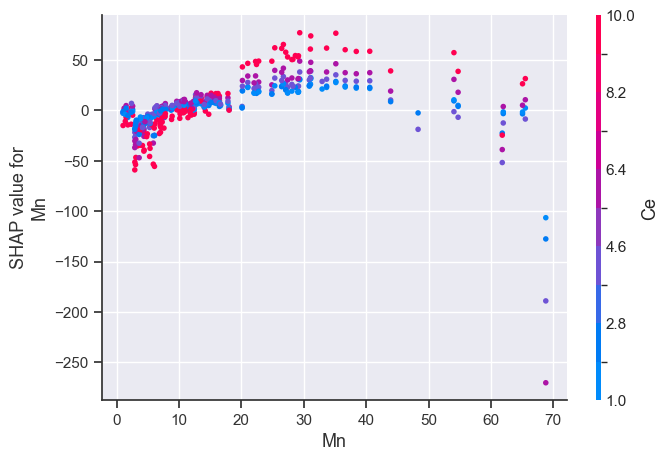

In [199]:
shap.dependence_plot('Mn',shap_values,X_train)

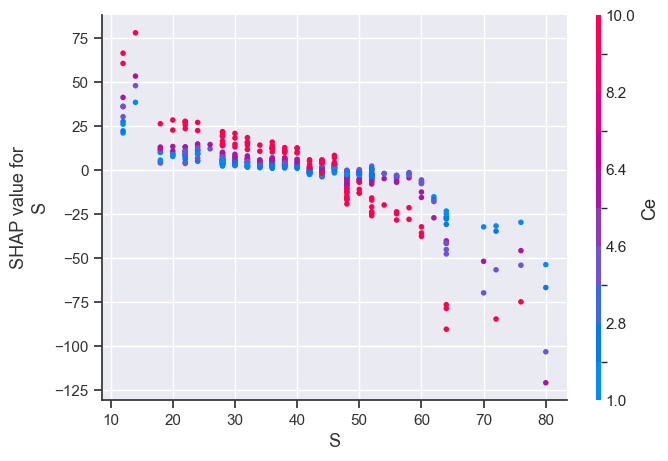

In [200]:
shap.dependence_plot('S',shap_values,X_train)

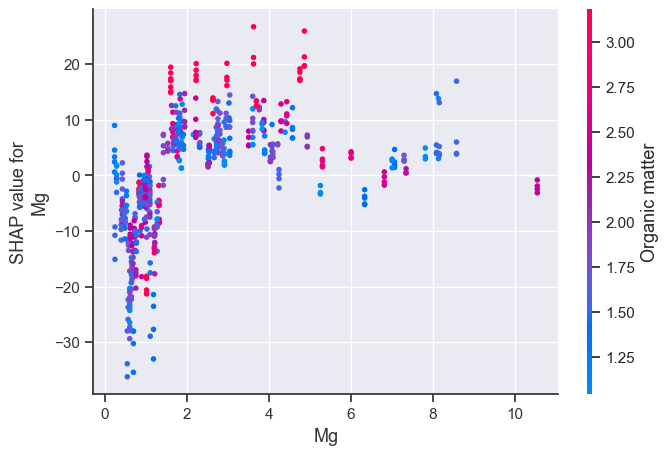

In [201]:
shap.dependence_plot('Mg',shap_values,X_train)